# Машинное обучение 1, ПМИ ФКН ВШЭ

## Семинар 4

## Подготовка данных

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Сегодня мы углубимся в одну из самых важных тем в машинном обучении - конструирование признаков (feature engineering). Качество вашей модели зависит не только от выбранного алгоритма, но и, в значительной степени, от того, как вы подготовите и представите данные.

Начнем мы с рассмотрения двух техник: трансформации признаков с помощью логарифмирования и бинаризации для захвата нелинейных зависимостей.

## Трансформация признаков и целевой переменной

Идея трансформации заключается в изменении шкалы или распределения данных, чтобы они лучше соответствовали предположениям модели, которую мы используем. Это особенно важно для линейных моделей.

### Логарифмирование

Воспользуется датасетом с ценами на дома, с которым мы уже сталкивались ранее ([House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)).

In [2]:
!wget  -O 'train_sem4.csv' -q 'https://www.dropbox.com/s/syfy4lb6xb7wdlx/_train_sem4.csv?dl=0'

In [3]:
data = pd.read_csv('train_sem4.csv')

data = data.drop(columns=["Id"])
y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

Посмотрим на распределение целевой переменной

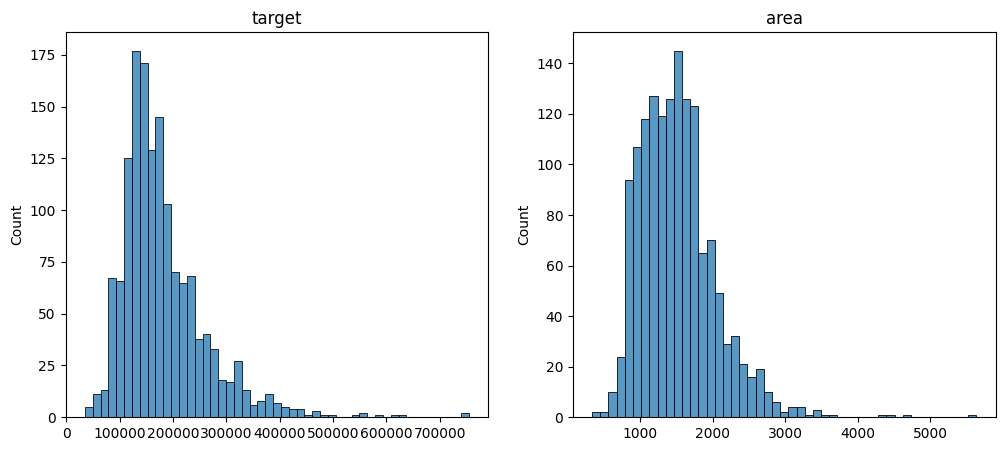

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.array(y), label='target')
plt.title('target')

plt.subplot(1, 2, 2)
sns.histplot(np.array(data.GrLivArea), label='area')
plt.title('area')
plt.show()

Видим, что распределения несимметричные с тяжёлыми правыми хвостами.

Оставим только числовые признаки, пропуски заменим средним значением.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

Если разбирать линейную регрессия с [вероятностной](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem04-linregr.pdf) точки зрения, то можно получить, что шум должен быть распределён нормально. Поэтому лучше, когда целевая переменная распределена также нормально.

Если прологарифмировать целевую переменную, то её распределение станет больше похоже на нормальное:

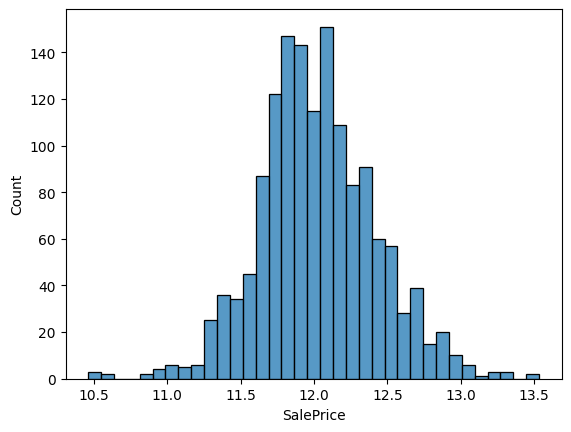

In [10]:
sns.histplot(np.log(y+1), label='target')
plt.show()

Сравним качество линейной регрессии в двух случаях:
1. Целевая переменная без изменений.
2. Целевая переменная прологарифмирована.

Не забудем вернуть во втором случае взять экспоненту от предсказаний!

In [11]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 32085.7681


In [12]:
model = Ridge()
model.fit(X_train, np.log(y_train+1))
y_pred = np.exp(model.predict(X_test))-1

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 26649.2742


Попробуем аналогично логарифмировать один из признаков, имеющих также смещённое распределение (этот признак был вторым по важности!)

In [13]:
X_train.GrLivArea = np.log(X_train.GrLivArea + 1)
X_test.GrLivArea = np.log(X_test.GrLivArea + 1)

In [14]:
model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 31893.8891


In [15]:
model = Ridge()
model.fit(X_train[numeric_features], np.log(y_train+1))
y_pred = np.exp(model.predict(X_test[numeric_features]))-1

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 25935.0780


Как видим, преобразование признаков влияет слабее. Признаков много, а вклад размывается по всем. К тому же, проверять распределение множества признаков технически сложнее, чем одной целевой переменной.

### Бинаризация

Мы уже смотрели, как полиномиальные признаки могут помочь при восстановлении нелинейной зависимости линейной моделью. Альтернативный подход заключается в бинаризации признаков. Мы разбиваем ось значений одного из признаков на куски (бины) и добавляем для каждого куска-бина новый признак-индикатор попадения в этот бин.

In [16]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
X = np.random.uniform(0, 1, size=100)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

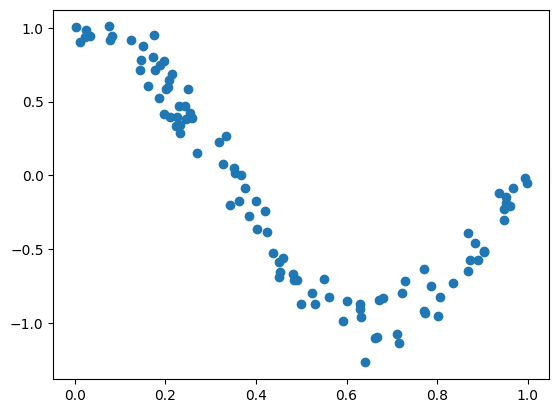

In [17]:
plt.scatter(X, y)

In [18]:
X = X.reshape((-1, 1))
thresholds = np.arange(0.2, 1.1, 0.2).reshape((1, -1))

X_expand = np.hstack((
    X,
    ((X > thresholds[:, :-1]) & (X <= thresholds[:, 1:])).astype(int)))

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [20]:
-np.mean(cross_val_score(
    LinearRegression(), X, y, cv=KFold(n_splits=3),
    scoring='neg_mean_squared_error'))

np.float64(0.20553980048560808)

In [21]:
-np.mean(cross_val_score(
    LinearRegression(), X_expand, y, cv=KFold(n_splits=3),
    scoring='neg_mean_squared_error'))

np.float64(0.05580385745900122)

Так линейная модель может лучше восстанавливать нелинейные зависимости.

## Нормализация данных

Посмотрим как ведут себя данные при разных способах нормализации.

Сгенерируем данные 100 точек из нормального $N(0, 5)$ и 100 точек из равномерного $U[0, 10]$

In [22]:
normal_data = np.random.normal(loc=0, scale=5, size=100)
uniform_data = np.random.uniform(low=5, high=10, size=100)

data = np.concatenate([normal_data, uniform_data])

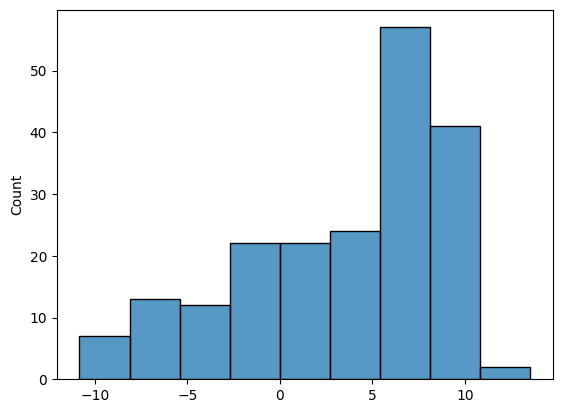

In [23]:
sns.histplot(data, label='points')
plt.show()

Standard Scaler:

$$x_n = \frac{x - \mu}{\sigma},$$

где $\mu$ -- среднее, а $\sigma$ -- стандартное отклонение.

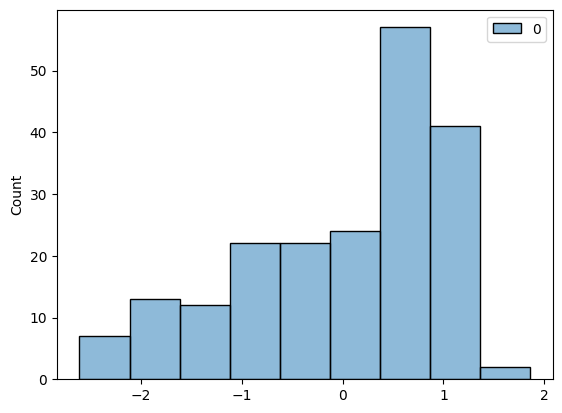

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standard = scaler.fit_transform(data[:, np.newaxis])

sns.histplot(data_standard, label='points')
plt.show()

MinMax/Uniform Scaler:

$$x_n = \frac{x - x_{min}}{x_{max} - x_{min}},$$

где $x_{min}$ -- минимальное значение, а $x_{max}$ -- максимальное значение.

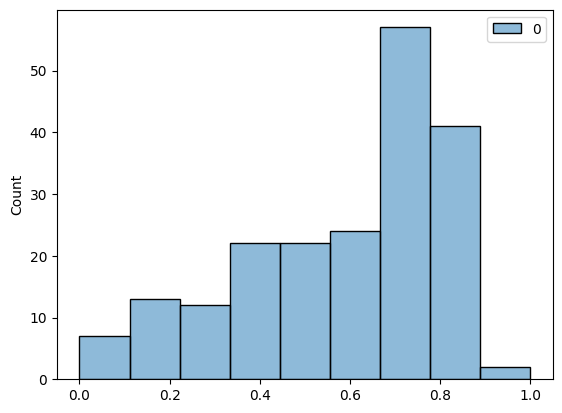

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_minmax = scaler.fit_transform(data[:, np.newaxis])

sns.histplot(data_minmax, label='points')
plt.show()

Robust Scaler

$$x_n = \frac{x - q(0.5)}{q(0.75) - q(0.25)},$$

где $q(k)$ -- $k$-ый квантиль. Такой Scaler меньше чувствителен к выбросам.

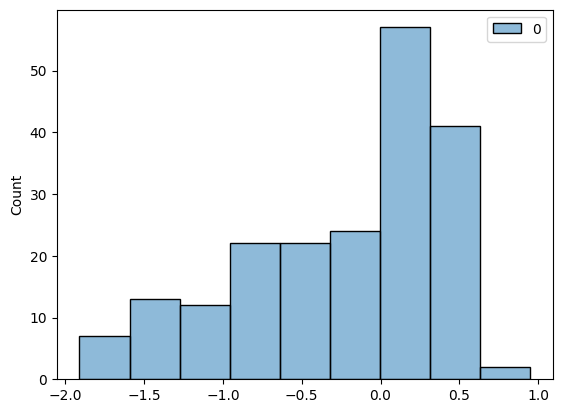

In [26]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data_robust = scaler.fit_transform(data[:, np.newaxis])

sns.histplot(data_robust, label='points')
plt.show()

L2 Нормализация:

$$x_n = \frac{x}{\|x\|_2}$$

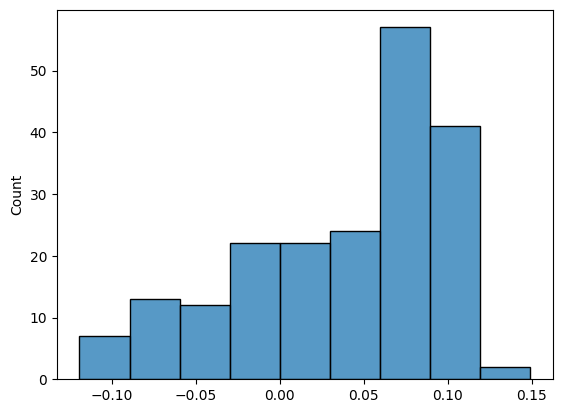

In [27]:
data_l2 = data / np.linalg.norm(data)
sns.histplot(data_l2, label='points')
plt.show()

Покажем на реальном примере, как нормализация данных помогает с повышением качества классификации. Рассмотрим датасет итальянских вин:

In [28]:
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

wine = load_wine()
X, y = wine.data, wine.target

wine_df = pd.DataFrame(X, columns=wine.feature_names)
wine_df["target"] = y
wine_df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Посмотрим на диапазоны значений признаков:

In [29]:
for i, feature in enumerate(wine.feature_names):
    print(f"{feature}: {X[:, i].min():.2f} - {X[:, i].max():.2f}")

alcohol: 11.03 - 14.83
malic_acid: 0.74 - 5.80
ash: 1.36 - 3.23
alcalinity_of_ash: 10.60 - 30.00
magnesium: 70.00 - 162.00
total_phenols: 0.98 - 3.88
flavanoids: 0.34 - 5.08
nonflavanoid_phenols: 0.13 - 0.66
proanthocyanins: 0.41 - 3.58
color_intensity: 1.28 - 13.00
hue: 0.48 - 1.71
od280/od315_of_diluted_wines: 1.27 - 4.00
proline: 278.00 - 1680.00


Как видно, значения некоторых признаков принимают значения не более 10, в то время как есть признак у которого минимальное значение больше сотни. Покажем, что путем нормализации этих данных можно значительно повысить метрики классификации:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Обучим логистическую регрессию на исходных данных:

In [34]:
model_raw = LogisticRegression(
    random_state=42,
    max_iter=5000
)
model_raw.fit(X_train, y_train)

y_pred_raw = model_raw.predict(X_test)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f'Accuracy: {accuracy_raw}')

Accuracy: 0.9555555555555556


Применим стандартную нормализацию данных:

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LogisticRegression(
    random_state=42,
    max_iter=1000
)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f'Accuracy: {accuracy_scaled}')

Accuracy: 1.0


Accuracy заметно выросло.

In [36]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LogisticRegression(
    random_state=42,
    max_iter=1000
)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f'Accuracy: {accuracy_scaled}')

Accuracy: 0.9777777777777777


Как видно нормализация данных может заметно повысить качество работы ML алгоритмов на данных.

Попробуем аналогично поступить с моделью на основе ближайших соседей.

Без нормализации:

In [37]:
from sklearn.neighbors import KNeighborsClassifier
model_raw = KNeighborsClassifier(
    n_neighbors=5,
    metric='euclidean'
)
model_raw.fit(X_train, y_train)

y_pred_raw = model_raw.predict(X_test)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f'Accuracy: {accuracy_raw}')

Accuracy: 0.7777777777777778


С нормализацией:

In [38]:
model_scaled = KNeighborsClassifier(
    n_neighbors=5,
    metric='euclidean'
)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f'Accuracy: {accuracy_scaled}')

Accuracy: 0.9333333333333333


В этом примере разница еще значительнее.

## Работа с текстовыми данными

Как правило, модели машинного обучения действуют в предположении, что матрица "объект-признак" является вещественнозначной, поэтому при работе с текстами сперва для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, tf-idf и пр. Рассмотрим их на примере [датасета](https://www.dropbox.com/s/f9xsff8xluriy95/banki_responses.json.bz2?dl=0) отзывов о банках.

Сперва загрузим данные:

In [39]:
data = fetch_20newsgroups(subset='all', categories=['comp.graphics', 'sci.med'])

Данные содержат тексты новостей, которые надо классифицировать на разделы.

In [40]:
data['target_names']

['comp.graphics', 'sci.med']

In [41]:
texts = data['data']
target = data['target']

Например:

In [42]:
texts[0]

'From: dyer@spdcc.com (Steve Dyer)\nSubject: Re: Analgesics with Diuretics\nOrganization: S.P. Dyer Computer Consulting, Cambridge MA\n\nIn article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:\n>I sometimes see OTC preparations for muscle aches/back aches that\n>combine aspirin with a diuretic.\n\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n>The idea seems to be to reduce\n>inflammation by getting rid of fluid. Does this actually work? \n\nThat\'s not the idea, and no, they don\'t work.\n\n-- \nSteve Dyer\ndyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer\n'

In [43]:
data['target_names'][target[0]]

'sci.med'

### Bag-of-words

Самый очевидный способ формирования признакового описания текстов — векторизация. Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(texts)

Результатом является разреженная матрица.

In [45]:
vectorizer.transform(texts[:1])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 86 stored elements and shape (1, 32548)>

In [46]:
print(vectorizer.transform(texts[:1]).indptr)
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[ 0 86]
[ 3905  3983  4143  4345  4665  4701  4712  5074  5176  5198  5242  5619
  5870  6348  6984  7232  7630  8267  8451  8460  8682  8733  8916  9557
 10811 10812 10901 10933 10971 11312 11488 13133 13226 13463 13866 14726
 14806 15682 15805 15952 16147 18002 18031 18373 18740 18781 18790 18936
 20420 21036 21164 21166 21494 21518 21622 21769 21839 21856 23589 23602
 24556 24592 24803 25502 25513 26464 26474 27021 27398 27518 27940 28199
 28286 28687 29187 29189 29264 29300 29500 29837 30702 31915 32005 32052
 32095 32392]
[2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 6 2 1 2 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 1 1 1 3 2 1 2 1
 2 3 2 1 3 1 1 2 2 1 1 1]


### TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:

$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D)$.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(texts)

На выходе получаем разреженную матрицу.

In [48]:
vectorizer.transform(texts[:1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 86 stored elements and shape (1, 32548)>

In [49]:
print(vectorizer.transform(texts[:1]).indptr)
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[ 0 86]
[ 3905  3983  4143  4345  4665  4701  4712  5074  5176  5198  5242  5619
  5870  6348  6984  7232  7630  8267  8451  8460  8682  8733  8916  9557
 10811 10812 10901 10933 10971 11312 11488 13133 13226 13463 13866 14726
 14806 15682 15805 15952 16147 18002 18031 18373 18740 18781 18790 18936
 20420 21036 21164 21166 21494 21518 21622 21769 21839 21856 23589 23602
 24556 24592 24803 25502 25513 26464 26474 27021 27398 27518 27940 28199
 28286 28687 29187 29189 29264 29300 29500 29837 30702 31915 32005 32052
 32095 32392]
[0.23738007 0.05913563 0.10946036 0.0819996  0.10531547 0.03925604
 0.15610804 0.02850602 0.03099918 0.03071828 0.10946036 0.05392398
 0.02634071 0.11869004 0.03432907 0.0833942  0.06679843 0.16490298
 0.06487218 0.09925063 0.04302873 0.12343474 0.08984071 0.10357777
 0.11869004 0.11500976 0.03418115 0.03886054 0.03809625 0.48428276
 0.04826154 0.09689049 0.04338328 0.01649287 0.06089811 0.07172143
 0.08719619 0.1325496  0.08913878 0.01987357 0.08913878 0.0865963

Заметим, что оба метода возвращают вектор длины 32548 (размер нашего словаря).

Заметим, что одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи **лемматизации** и **стемминга**.

### Стемминг

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) –  это процесс нахождения основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.

**Примеры стемминга:**

| Word        | Stem           |
| ----------- |:-------------:|
| вагон | вагон |
| вагона | вагон |
| вагоне | вагон |
| вагонов | вагон |
| вагоном | вагон |
| вагоны | вагон |
| важная | важн |
| важнее | важн |
| важнейшие | важн |
| важнейшими | важн |
| важничал | важнича |
| важно | важн |

[Snowball](http://snowball.tartarus.org/) – фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке – списки окончаний для разных чистей речи, разных склонений и т.д. Пример алгоритма для русского языка – [Russian stemming](http://snowballstem.org/algorithms/russian/stemmer.html).

In [50]:
import nltk
stemmer = nltk.stem.snowball.RussianStemmer()

In [51]:
print(stemmer.stem(u'машинное'), stemmer.stem(u'обучение'))

машин обучен


In [52]:
stemmer = nltk.stem.snowball.EnglishStemmer()

def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in tqdm(texts[:1000]):
    stemmed_texts.append(stem_text(t, stemmer))

100%|██████████| 1000/1000 [00:03<00:00, 328.44it/s]


In [53]:
print(texts[0])

From: dyer@spdcc.com (Steve Dyer)
Subject: Re: Analgesics with Diuretics
Organization: S.P. Dyer Computer Consulting, Cambridge MA

In article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:
>I sometimes see OTC preparations for muscle aches/back aches that
>combine aspirin with a diuretic.

You certainly do not see OTC preparations advertised as such.
The only such ridiculous concoctions are nostrums for premenstrual
syndrome, ostensibly to treat headache and "bloating" simultaneously.
They're worthless.

>The idea seems to be to reduce
>inflammation by getting rid of fluid. Does this actually work? 

That's not the idea, and no, they don't work.

-- 
Steve Dyer
dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer



In [54]:
print(stemmed_texts[0])

from: dyer@spdcc.com (steve dyer) subject: re: analges with diuret organization: s.p. dyer comput consulting, cambridg ma in articl <ofk=lve00wb2avukto@andrew.cmu.edu> lawrenc curcio <lc2b+@andrew.cmu.edu> writes: >i sometim see otc prepar for muscl aches/back ach that >combin aspirin with a diuretic. you certain do not see otc prepar advertis as such. the onli such ridicul concoct are nostrum for premenstru syndrome, ostens to treat headach and "bloating" simultaneously. they'r worthless. >the idea seem to be to reduc >inflamm by get rid of fluid. doe this actual work? that not the idea, and no, they don't work. -- steve dyer dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dy


Как видим, стеммер работает не очень быстро и запускать его для всей выборки достаточно накладно.

### Лемматизация

[Лемматизация](https://en.wikipedia.org/wiki/Lemmatisation) — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Например, для русского языка есть библиотека pymorphy3.

In [ ]:
!pip install pymorphy3

In [59]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [60]:
morph.parse('играющих')[0]

Parse(word='играющих', tag=OpencorporaTag('PRTF,Subx,impf,tran,pres,actv plur,gent'), normal_form='играть', score=0.6, methods_stack=((DictionaryAnalyzer(), 'играющих', 1694, 34),))

Сравним работу стеммера и лемматизатора на примере:

In [61]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem('играющих'))

игра


In [62]:
print(morph.parse('играющих')[0].normal_form)

играть


## Транзакционные данные

Напоследок посмотрим, как можно извлекать признаки из транзакционных данных.

Транзакционные данные характеризуются тем, что есть много строк, характеризующихся моментов времени и некоторым числом (суммой денег, например). При этом если это банк, то каждому человеку принадлежит не одна транзакция, а чаще всего надо предсказывать некоторые сущности для клиентов. Таким образом, надо получить признаки для пользователей из множества их транзакций. Этим мы и займёмся.

Для примера возьмём данные [отсюда](https://www.kaggle.com/regivm/retailtransactiondata/). Задача детектирования фродовых клиентов.

In [63]:
!wget  -O 'Retail_Data_Response.csv' -q 'https://www.dropbox.com/s/le9icl9syo22thh/Retail_Data_Response.csv?dl=0'
!wget  -O 'Retail_Data_Transactions.csv' -q 'https://www.dropbox.com/s/obsxryxpfsdz3ut/Retail_Data_Transactions.csv?dl=0'

In [64]:
customers = pd.read_csv('Retail_Data_Response.csv')
transactions = pd.read_csv('Retail_Data_Transactions.csv')

In [65]:
customers.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [66]:
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [68]:
import datetime as datetime

transactions.trans_date = transactions.trans_date.apply(
    lambda x: datetime.datetime.strptime(x, '%d-%b-%y'))

Посмотрим на распределение целевой переменной:

In [ ]:
customers.response.mean()

0.09398605461940732

Получаем примерно 1 к 9 положительных примеров. Если такие данные разбивать на части для кросс валидации, то может получиться так, что в одну из частей попадёт слишком мало положительных примеров, а в другую — наоборот. На случай такого неравномерного баланса классов есть StratifiedKFold, который бьёт данные так, чтобы баланс классов во всех частях был одинаковым.

In [69]:
from sklearn.model_selection import StratifiedKFold

Когда строк на каждый объект много, можно считать различные статистики. Например, средние, минимальные и максимальные суммы, потраченные клиентом, количество транзакий, ...

In [70]:
agg_transactions = transactions.groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

data = pd.merge(customers, agg_transactions, how='left', on='customer_id')

data.head()

,customer_id,response,mean,std,count,min,max
0,CS1112,0,67.466667,19.766012,15,36,105
1,CS1113,0,74.500000,21.254102,20,36,98
2,CS1114,1,75.368421,21.341692,19,37,105
3,CS1115,1,75.409091,18.151896,22,41,104
4,CS1116,1,65.923077,22.940000,13,40,105


In [71]:
from sklearn.linear_model import LogisticRegression

np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

np.float64(0.7133553588190397)

Но каждая транзакция снабжена датой! Можно посчитать статистики только по свежим транзакциям. Добавим их.

In [72]:
transactions.trans_date.min(), transactions.trans_date.max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

In [73]:
agg_transactions = transactions.loc[transactions.trans_date.apply(
    lambda x: x.year == 2014)].groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

In [74]:
data = pd.merge(data, agg_transactions, how='left', on='customer_id', suffixes=('', '_2014'))
data = data.fillna(0)

In [75]:
np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

np.float64(0.7492876483689002)

Можно также считать дату первой и последней транзакциями пользователей, среднее время между транзакциями и прочее.

Добавим к данным шумный признак.

In [76]:
np.random.seed(42)
noise_mean = 0
noise_std = 10
data['noisy_feature'] = np.random.normal(noise_mean, noise_std, len(data))
noise_mean = -5
noise_std = 10
data['noisy_feature1'] = np.random.normal(noise_mean, noise_std, len(data)) + data["min"]
noise_mean = 5
noise_std = 10
data['noisy_feature2'] = np.random.normal(noise_mean, noise_std, len(data)) + data["max"]
noise_mean = 5
noise_std = 0
data['noisy_feature3'] = np.random.normal(noise_mean, noise_std, len(data)) + data["max"]
data = data.fillna(0)

In [77]:
np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

np.float64(0.7417476274854972)

Метрика чуть-чуть упала. Посмотрим на веса признаков в моделях.


Веса признаков:
       feature  coefficient  abs_coefficient
noisy_feature3    -1.063181         1.063181
           max     1.055953         1.055953
    count_2014     0.164641         0.164641
         count     0.063727         0.063727
      std_2014    -0.025685         0.025685
           min     0.024862         0.024862
      min_2014    -0.020096         0.020096
      max_2014     0.019673         0.019673
          mean     0.014903         0.014903
     mean_2014     0.009337         0.009337
noisy_feature2    -0.008216         0.008216
           std     0.008184         0.008184
noisy_feature1    -0.003090         0.003090
 noisy_feature     0.000293         0.000293


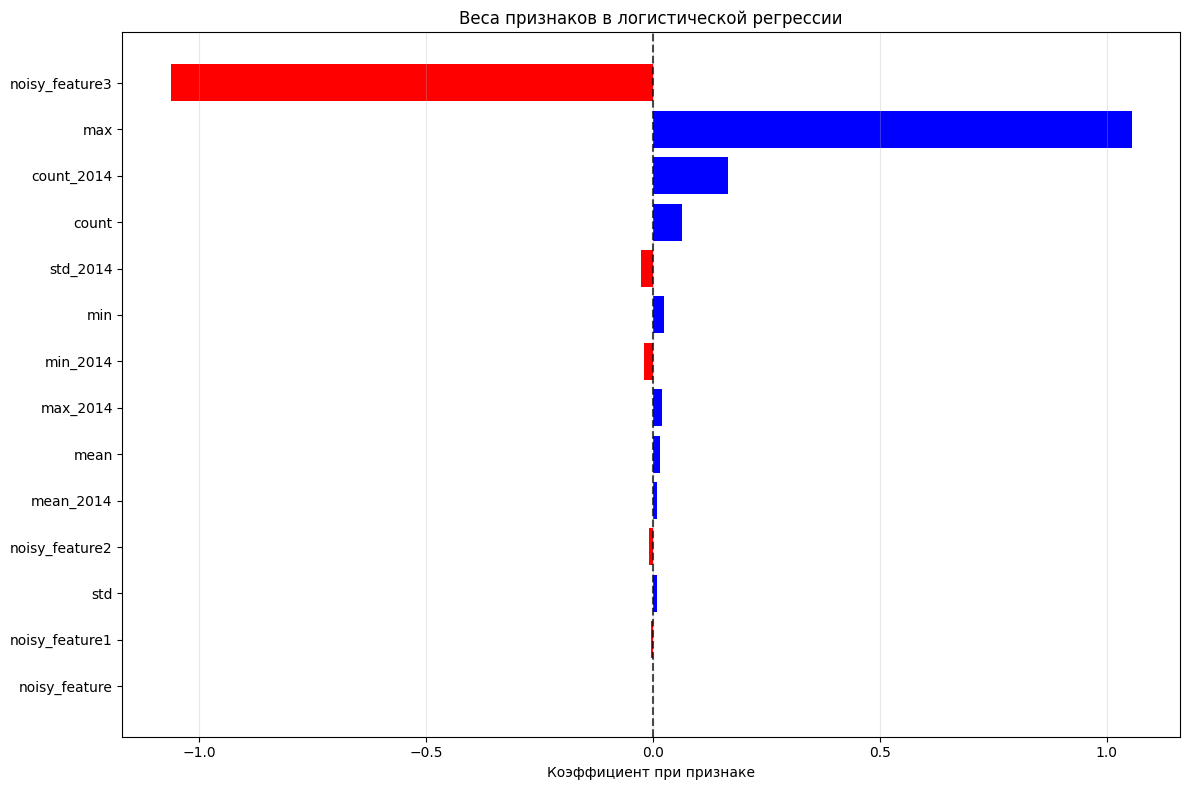

In [78]:
X = data.drop(['customer_id', 'response'], axis=1)
y = data.response

# Обучаем модель
model = LogisticRegression(solver='newton-cg')
model.fit(X, y)

# Получаем веса признаков
feature_weights = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
})

feature_weights = feature_weights.sort_values('abs_coefficient', ascending=False)

print("\nВеса признаков:")
print(feature_weights.to_string(index=False))

top_features = feature_weights.head(20)
plt.figure(figsize=(12, 8))
colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel('Коэффициент при признаке')
plt.title('Веса признаков в логистической регрессии')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Как видно у шумных признаков веса минимальные.